In [127]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader, DataListLoader
import IPython.display
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

from load_data import BatchData
import summary

USE_GPU = True
HIDDEN_CHANNELS = 10
LATENT_DIMS =   4
NUM_GCN = 4 #assuming symmetric encoder-decoder network

device = torch.device("cuda")

In [128]:
class Encoder(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, latent_dims, num_layers):
        super(Encoder, self).__init__()
        self.linear = torch.nn.Linear(num_features, hidden_channels)
        self.conv_layers = torch.nn.ModuleList()
        for i in range(num_layers-2):
            self.conv_layers.append(GCNConv(hidden_channels, hidden_channels)) # GCN layers 2 to num_layers-1
        self.conv_layers.append(GCNConv(hidden_channels, latent_dims)) # GCN layer num_layers
        self.num_layers = num_layers

    def forward(self, x, edge_index, edge_attr):
    # Linear transformation
        edge_attr = edge_attr.view(edge_attr.size(0), -1)
    # Concatenate the node features and edge features
        print(x.shape)
        print(edge_attr.shape)
        x = torch.cat([x[edge_index[0]], x[edge_index[1]], edge_attr], dim=1)
        print(x.shape)
        x = self.linear(x)
        x = F.relu(x)
        # Message passing
        for i in range(self.num_layers-1):
            x = self.conv_layers[i](x, edge_index)
            x = F.relu(x)
        # Non-linearity
        x = self.conv_layers[-1](x, edge_index)
        return x

In [129]:
class Decoder(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, latent_dims):
        super(Decoder, self).__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(latent_dims, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, num_node_features)
        )

    def forward(self, z, edge_index):
        # Compute node embeddings
        z = self.mlp(z)
        # Compute probability of edge existence
        prob = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        prob = torch.sigmoid(prob)
        return prob

In [130]:
class Autoencoder(torch.nn.Module):
  def __init__(self, encoder, decoder):
    super(Autoencoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    
  def forward(self, x, edge_index, edge_attr):
    # Apply the MLP to the feature vectors
    z = self.encoder(x, edge_index, edge_attr)
    # Apply the GNN to the graph and feature vectors
    pred = self.decoder(z, edge_index)
    return pred

In [131]:
def displayStats(loader):
        for batch in loader:
            print(batch["x"].shape)
            print(batch["edge_attr"].shape)

            data = batch  # Get the first graph object.
            print(data)
            print('==============================================================')
            # Gather some statistics about the graph.
            print(f'Number of nodes: {data.num_nodes}')
            print(f'Number of edges: {data.num_edges}')
            print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
            print(f'Number of node features: {data.num_features}')
            print(f'Number of edge features: {data.edge_attr.shape[1]}')
            # print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
            print(f'Has isolated nodes: {data.has_isolated_nodes()}')
            print(f'Has self-loops: {data.has_self_loops()}')
            print(f'Is undirected: {data.is_undirected()}')
            break
        return None

def test_visualise(graph):
    g = torch_geometric.utils.to_networkx(graph, to_undirected=True)
    nx.draw_networkx(g)
    plt.show()
    return None

def getDataDims(loader):
    return [loader.dataset[0].num_features, loader.dataset[0].edge_attr.shape[1]]


In [132]:
def train_model(model, loader_train, loader_test, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_history =[]
    roc_history =[]
    ap_history =[]


    for epoch in range(num_epochs):
        for batch in loader_train:
            if(USE_GPU):
                x           = batch["x"].to("cuda")
                edge_index  = batch["edge_index"].to("cuda")
                edge_attr   = batch["edge_attr"].to("cuda")
                y           = batch["y"].to("cuda")
            probs = model.forward(x, edge_index, edge_attr)
            loss = F.binary_cross_entropy(probs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            roc_auc, ap = test(model, loader_test)
            
        loss_history.append(float(loss.item()))
        roc_history.append(roc_auc)
        ap_history.append(ap)    
        if(epoch%1==0):
                print(f"Epoch {epoch}, Loss: {loss.item():.4f}, ROC Score: {roc_auc:.4f}, AP Score: {ap:.4f}")
        del loss
        del probs    
        torch.cuda.empty_cache()
    return loss_history, roc_history, ap_history

def test(model, loader):
    for batch in loader:
        if(USE_GPU):
            x           = batch["x"].to("cuda")
            edge_index  = batch["edge_index"].to("cuda")
            edge_attr   = batch["edge_attr"].to("cuda")
            y           = batch["y"].to("cuda")
        probs = model.forward(x, edge_index)
    y, pred = y.detach().cpu().numpy(), probs.detach().cpu().numpy()

    return roc_auc_score(y, pred), average_precision_score(y, pred)
    

In [133]:
def init_model(num_nf, num_hidden_channels, latent_dims, num_gcn, loader):
    encoder = Encoder(num_nf, num_hidden_channels, latent_dims, num_gcn)
    decoder = Decoder(num_nf, num_hidden_channels, latent_dims)
    model = Autoencoder(encoder, decoder)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    print(summary.summary(model, loader.dataset[0]["x"], loader.dataset[0]["edge_index"], loader.dataset[0]["edge_attr"]))
    return model

In [134]:
## TODO: Change to DataListLoader to allow batches to be subscriptable and possibly add functionality for parallelisation

## TODO: init BatchData with an index range instead to allow 80 20 train-test split

loader_train = DataLoader(BatchData(0,1), batch_size=16, pin_memory=True, num_workers=4)
print("Train Set Batch Count:", len(loader_train))
displayStats(loader=loader_train)
loader_test = DataLoader(BatchData(9,10), batch_size=16, pin_memory=True, num_workers=4)
print("Test Set Batch Count:", len(loader_train))
displayStats(loader=loader_test)
num_nf, num_ef = getDataDims(loader=loader_train)


Loading:
../data/batch_1_0
Train Set Batch Count: 63
torch.Size([4822, 6])
torch.Size([67604, 4])
DataBatch(x=[4822, 6], edge_index=[2, 67604], edge_attr=[67604, 4], y=[67604], batch=[4822], ptr=[17])
Number of nodes: 4822
Number of edges: 67604
Average node degree: 14.02
Number of node features: 6
Number of edge features: 4
Has isolated nodes: True
Has self-loops: False
Is undirected: False
Loading:
../data/batch_1_9
Test Set Batch Count: 63
torch.Size([4754, 6])
torch.Size([64870, 4])
DataBatch(x=[4754, 6], edge_index=[2, 64870], edge_attr=[64870, 4], y=[64870], batch=[4754], ptr=[17])
Number of nodes: 4754
Number of edges: 64870
Average node degree: 13.65
Number of node features: 6
Number of edge features: 4
Has isolated nodes: True
Has self-loops: False
Is undirected: False


In [135]:
model = init_model(num_nf, HIDDEN_CHANNELS, LATENT_DIMS, NUM_GCN, loader_train)

torch.Size([350, 6])
torch.Size([8138, 4])
torch.Size([8138, 16])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8138x16 and 6x10)

In [ ]:
if(USE_GPU):
    model.to(device = "cuda")
    torch.cuda.empty_cache()

print("Training on GPU:", next(model.parameters()).is_cuda)
loss_hist, roc_hist, ap_hist = train_model(model, loader_train, loader_test, num_epochs = 25)

Training on GPU: True
Epoch 0, Loss: 0.6932, ROC Score: 0.7205, AP Score: 0.4887
Epoch 1, Loss: 0.6839, ROC Score: 0.6107, AP Score: 0.4295
Epoch 2, Loss: 0.7023, ROC Score: 0.8196, AP Score: 0.5264
Epoch 3, Loss: 0.3291, ROC Score: 0.8327, AP Score: 0.6051
Epoch 4, Loss: 0.3054, ROC Score: 0.8416, AP Score: 0.6255
Epoch 5, Loss: 0.2964, ROC Score: 0.8510, AP Score: 0.6773
Epoch 6, Loss: 0.2930, ROC Score: 0.8527, AP Score: 0.6901
Epoch 7, Loss: 0.2914, ROC Score: 0.8555, AP Score: 0.6969
Epoch 8, Loss: 0.2906, ROC Score: 0.8577, AP Score: 0.7051
Epoch 9, Loss: 0.2891, ROC Score: 0.8592, AP Score: 0.7135
Epoch 10, Loss: 0.2897, ROC Score: 0.8533, AP Score: 0.6914
Epoch 11, Loss: 0.2889, ROC Score: 0.8562, AP Score: 0.7009
Epoch 12, Loss: 0.2874, ROC Score: 0.8594, AP Score: 0.7155
Epoch 13, Loss: 0.2851, ROC Score: 0.8600, AP Score: 0.7192
Epoch 14, Loss: 0.2855, ROC Score: 0.8604, AP Score: 0.7161
Epoch 15, Loss: 0.2837, ROC Score: 0.8603, AP Score: 0.7205
Epoch 16, Loss: 0.2819, ROC 

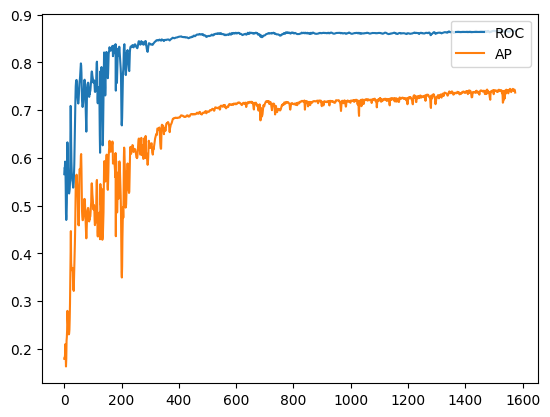

In [ ]:

plt.plot(roc_hist, label="ROC")
plt.plot(ap_hist, label="AP")
plt.legend(loc="upper right")
plt.show()

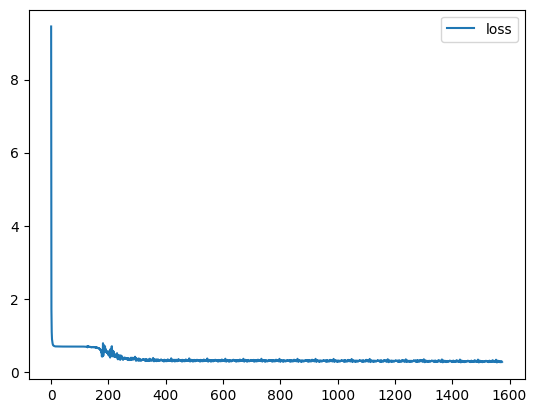

In [ ]:
plt.plot(loss_hist, label="loss")
plt.legend()
plt.show()
roc_auc, ap = test(model, loader_test)

In [ ]:
print("ROC:{}%".format(roc_auc*100))
print("Average Precision:{}%".format(ap*100))

ROC:86.57885243934498%
Average Precision:73.68401056323131%
